The dataset can be accessed [from this source](https://www.kaggle.com/datasets/kishanyadav/inshort-news?select=inshort_news_data-1.csv).

Import Library

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import Dataset

In [17]:
url = 'https://raw.githubusercontent.com/dimsdika12/News-Classification/main/dataset/inshort_news_data-1.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,news_headline,news_article,news_category
0,0,50-year-old problem of biology solved by Artif...,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,1,Microsoft Teams to stop working on Internet Ex...,Microsoft Teams will stop working on Internet ...,technology
2,2,Hope US won't erect barriers to cooperation: C...,"China, in response to reports of US adding Chi...",technology
3,3,Global smartphone sales in Q3 falls 5.7% to 36...,The global smartphone sales in the third quart...,technology
4,4,EU hoping Biden will clarify US position on di...,The European Union (EU) is hoping that US Pres...,technology


Delete unused columns

In [18]:
df.drop(['Unnamed: 0', 'news_headline'], axis=1, inplace=True)
df.head()

,news_article,news_category
0,DeepMind's AI system 'AlphaFold' has been reco...,technology
1,Microsoft Teams will stop working on Internet ...,technology
2,"China, in response to reports of US adding Chi...",technology
3,The global smartphone sales in the third quart...,technology
4,The European Union (EU) is hoping that US Pres...,technology


Count the number of null values in each column

In [19]:
df.isnull().sum()

news_article     0
news_category    0
dtype: int64

distribution of genres

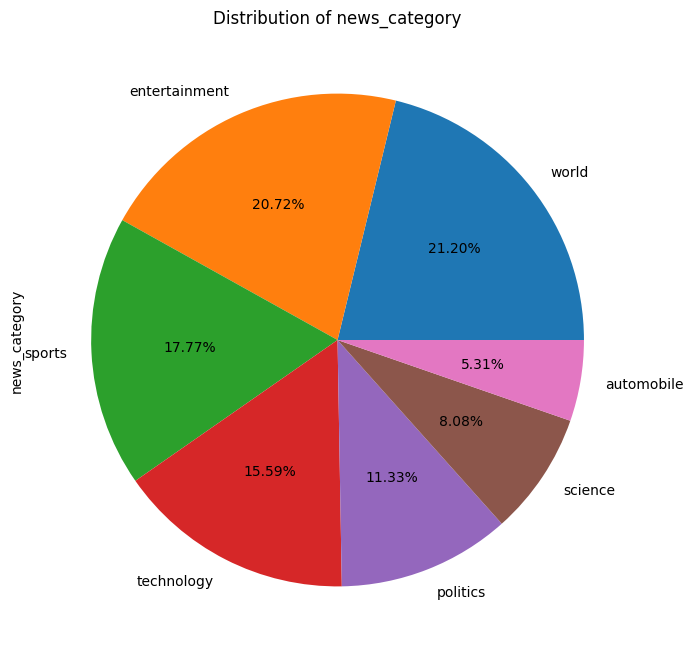

In [20]:
news_category_counts = df["news_category"].value_counts()
plt.figure(figsize=(8, 8))
news_category_counts.plot(kind="pie", autopct="%.2f%%")
plt.title("Distribution of news_category")
plt.show()

Delete some genres that will not be used (used top 4)

In [21]:
news_category_to_drop = ['automobile', 'science', 'politics']
df.drop(df[df['news_category'].isin(news_category_to_drop)].index, axis=0, inplace=True)

Convert categorical data into a numerical representation. For the 'genre' column, use One-hot encoding

In [22]:
category = pd.get_dummies(df.news_category)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='news_category')
df_new

,news_article,entertainment,sports,technology,world
0,DeepMind's AI system 'AlphaFold' has been reco...,0,0,1,0
1,Microsoft Teams will stop working on Internet ...,0,0,1,0
2,"China, in response to reports of US adding Chi...",0,0,1,0
3,The global smartphone sales in the third quart...,0,0,1,0
4,The European Union (EU) is hoping that US Pres...,0,0,1,0
...,...,...,...,...,...
4804,"Speaking about dealing with self-doubt, actres...",1,0,0,0
4805,Speaking about her film 'Mardaani 2' completin...,1,0,0,0
4806,"Arjun Rampal, Sunny Leone and Digangana Suryav...",1,0,0,0
4807,Singer Shawn Mendes apologised after using the...,1,0,0,0


convert the values from the dataframe into the numpy array data type

In [23]:
article = df_new['news_article'].values
label = df_new[['entertainment','sports','technology','world']].values

Split dataset for training and data for testing.

In [24]:
article_train, article_test, label_train, label_test = train_test_split(article, label, test_size=0.2)

In [25]:
print("Number of data entries in article_train:", article_train.shape[0])
print("Number of data entries in article_test:", article_test.shape[0])
print("Number of data entries in label_train:", label_train.shape[0])
print("Number of data entries in label_test:", label_test.shape[0])

Number of data entries in article_train: 2900
Number of data entries in article_test: 726
Number of data entries in label_train: 2900
Number of data entries in label_test: 726


aplly NLTK

In [26]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokenizer = RegexpTokenizer(r"\w+")
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words and w.isalpha()]
    return ' '.join(filtered_sentence)

article_train = [preprocess_text(text) for text in article_train]
article_test = [preprocess_text(text) for text in article_test]

Initializes a tokenizer, fits it on training and test synopses, converts text to sequences, and then pads the sequences for further processing.

In [27]:
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
tokenizer.fit_on_texts(article_train)
#tokenizer.fit_on_texts(article_test)

training_sequences = tokenizer.texts_to_sequences(article_train)
test_sequences = tokenizer.texts_to_sequences(article_test)

maxlen = 500
padded_training = pad_sequences(training_sequences, maxlen=maxlen, truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=maxlen, truncating='post')

Create model

In [28]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train model

In [29]:
class MinimumAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
        print("\nReached minimum accuracy of 90% on both training and validation sets!")
        self.model.stop_training = True
callback = MinimumAccuracyCallback()
history = model.fit(padded_training, label_train, epochs=50,
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callback])

Epoch 1/50
91/91 - 66s - loss: 1.3496 - accuracy: 0.3290 - val_loss: 1.0763 - val_accuracy: 0.4477 - 66s/epoch - 720ms/step
Epoch 2/50
91/91 - 61s - loss: 1.2595 - accuracy: 0.5559 - val_loss: 0.7288 - val_accuracy: 0.6488 - 61s/epoch - 675ms/step
Epoch 3/50
91/91 - 62s - loss: 0.4001 - accuracy: 0.8724 - val_loss: 0.2021 - val_accuracy: 0.9408 - 62s/epoch - 686ms/step
Epoch 4/50

Reached minimum accuracy of 90% on both training and validation sets!
91/91 - 61s - loss: 0.1589 - accuracy: 0.9552 - val_loss: 0.1836 - val_accuracy: 0.9421 - 61s/epoch - 674ms/step


plot loss and accuracy

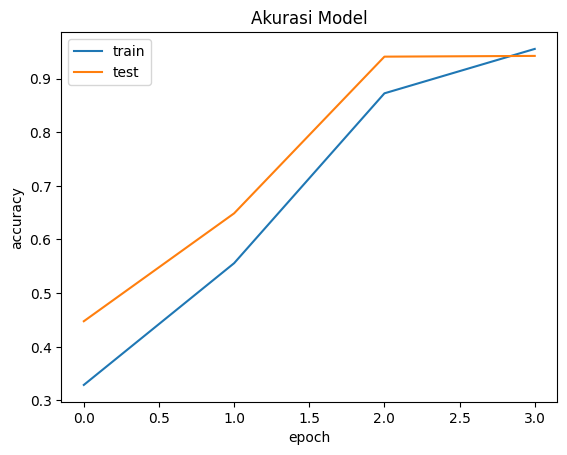

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

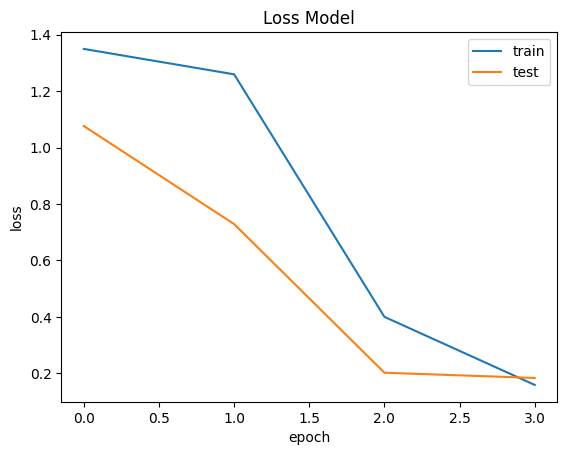

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()